In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# -------- range of the variables ----------
V_S = 7.0                   # service speed [kn]
range_D     = [0.5, 0.8]
range_AEdAO = [0.3, 1.05]
range_PdD   = [0.5, 1.4]
range_Z     = [2, 7]

# Define the lower and upper bounds for each variable
lower_bounds = [range_D[0], range_AEdAO[0], range_PdD[0]]
upper_bounds = [range_D[1], range_AEdAO[1], range_PdD[1]]

Load files

In [3]:
import csv
from os import chdir

def load_best_result(seed, solver_name):
    filename = dir_name+'best_results_' + str(seed) + '_' + solver_name + '.csv'
    history = []
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file, delimiter=' ', quotechar='|')
        counter = 0
        for row in reader:
            if counter == 1:
                params = row
            if counter == 3:
                history = row
            counter += 1
    # clean  
    params  = params[0].split(',')
    if len(history) > 0 and len(history[0]) > 2:
        history = history[0].split(',')
        history = [float(h) for h in history]
    D       = float(params[0])
    AEdAO   = float(params[1])
    PdD     = float(params[2])
    Z       = int(params[3]) if len(params[3]) == 1 else int(float(params[3]))
    fitness = float(params[6])

    result = [Z, (D, AEdAO, PdD), fitness, history]
    return result

def get_solver_results(solver_filename):
    results = []
    for seed in range(0, 10):
        result = load_best_result(seed, solver_filename)
        results.append(result)
    return results


def get_solver_results_df(solver_filename):
    data = {'D': [], 'AEdAO': [], 'PdD': [], 'Z': [], 'Brake Power': [], 'Seed': []}
    df = pd.DataFrame(data)
    for seed in range(0, 10):
        result = load_best_result(seed, solver_filename)
        Z, (D, AEdAO, PdD), fitness, history = result
        new_data = {'D': D, 'AEdAO': AEdAO, 'PdD': PdD, 'Z': int(Z), 'Brake Power': -fitness, 'Seed': seed}
        df = pd.concat([df, pd.DataFrame(new_data, index=[0])], ignore_index=True)
    return df

load files

In [4]:
dir_name = 'best_results/7_0/'

results = get_solver_results_df('original')
results['Algoritmo'] = 'DE Replicated'
results['VS'] = 7.0
df_results = results

results = get_solver_results_df('openaies')
results['Algoritmo'] = 'OpenAI-ES'
results['VS'] = 7.0
df_results = pd.concat([df_results, results], ignore_index=True)

results = get_solver_results_df('cmaes')
results['Algoritmo'] = "CMA-ES"
results['VS'] = 7.0
df_results = pd.concat([df_results, results], ignore_index=True)

# --------------------------------
dir_name = 'best_results/7_5/'

results = get_solver_results_df('original')
results['Algoritmo'] = 'DE Replicated'
results['VS'] = 7.5
df_results = pd.concat([df_results, results], ignore_index=True)

results = get_solver_results_df('openaies')
results['Algoritmo'] = 'OpenAI-ES'
results['VS'] = 7.5
df_results = pd.concat([df_results, results], ignore_index=True)

results = get_solver_results_df('cmaes')
results['Algoritmo'] = "CMA-ES"
results['VS'] = 7.5
df_results = pd.concat([df_results, results], ignore_index=True)

# ---------
dir_name = 'best_results/8_0/'


results = get_solver_results_df('original_mod')
results['Algoritmo'] = 'DE Proposed'
results['VS'] = 8.0
df_results = pd.concat([df_results, results], ignore_index=True)

results = get_solver_results_df('openaies')
results['Algoritmo'] = 'OpenAI-ES'
results['VS'] = 8.0
df_results = pd.concat([df_results, results], ignore_index=True)


results = get_solver_results_df('cmaes')
results['Algoritmo'] = "CMA-ES"
results['VS'] = 8.0
df_results = pd.concat([df_results, results], ignore_index=True)


# ---------
dir_name = 'best_results/8_5/'


results = get_solver_results_df('original_mod')
results['Algoritmo'] = 'DE Proposed'
results['VS'] = 8.5
df_results = pd.concat([df_results, results], ignore_index=True)

results = get_solver_results_df('openaies')
results['Algoritmo'] = 'OpenAI-ES'
results['VS'] = 8.5
df_results = pd.concat([df_results, results], ignore_index=True)


results = get_solver_results_df('cmaes')
results['Algoritmo'] = "CMA-ES"
results['VS'] = 8.5
df_results = pd.concat([df_results, results], ignore_index=True)

In [5]:

dir_name = 'best_results/7_0/'

results = get_solver_results_df('original_mod')
results['Algoritmo'] = 'DE Proposed'
results['VS'] = 7.0
df_results = pd.concat([df_results, results], ignore_index=True)

dir_name = 'best_results/7_5/'

results = get_solver_results_df('original_mod')
results['Algoritmo'] = 'DE Proposed'
results['VS'] = 7.5
df_results = pd.concat([df_results, results], ignore_index=True)

In [6]:
len(df_results)

140

In [7]:
df_results

,D,AEdAO,PdD,Z,Brake Power,Seed,Algoritmo,VS
0,0.8,0.651723,0.690962,5.0,81.472631,0.0,DE Replicated,7.0
1,0.8,0.628734,0.662074,5.0,81.419681,1.0,DE Replicated,7.0
2,0.8,0.652604,0.665862,5.0,81.492075,2.0,DE Replicated,7.0
3,0.8,0.625044,0.657868,5.0,81.421505,3.0,DE Replicated,7.0
4,0.8,0.631930,0.669280,5.0,81.412759,4.0,DE Replicated,7.0
...,...,...,...,...,...,...,...,...
135,0.8,0.726686,0.691480,5.0,106.331618,5.0,DE Proposed,7.5
136,0.8,0.862611,0.732383,6.0,106.375576,6.0,DE Proposed,7.5
137,0.8,0.875320,0.717682,6.0,106.522553,7.0,DE Proposed,7.5
138,0.8,0.824743,0.657685,5.0,106.492711,8.0,DE Proposed,7.5


show info

In [8]:
df_results.groupby(['VS', 'Algoritmo'])['Brake Power'].mean()

VS   Algoritmo    
7.0  CMA-ES            81.409024
     DE Proposed       81.438459
     DE Replicated     81.468037
     OpenAI-ES         81.714656
7.5  CMA-ES           106.218462
     DE Proposed      106.444867
     DE Replicated    106.457664
     OpenAI-ES        106.564368
8.0  CMA-ES           135.579539
     DE Proposed      135.916389
     OpenAI-ES        136.752065
8.5  CMA-ES           169.883213
     DE Proposed      170.465411
     OpenAI-ES        171.173398
Name: Brake Power, dtype: float64

Compare

In [9]:
# Find the index of the row with the minimal fitness value
min_fitness_index = df_results.groupby(['VS'])['Brake Power'].idxmin()

# Get the row with the minimal fitness value
min_fitness_row = df_results.loc[min_fitness_index]

min_fitness_row

,D,AEdAO,PdD,Z,Brake Power,Seed,Algoritmo,VS
26,0.799998,0.632247,0.669962,5.0,81.404509,6.0,CMA-ES,7.0
50,0.799999,0.704166,0.663303,5.0,106.193568,0.0,CMA-ES,7.5
88,0.799997,0.809078,0.682077,6.0,135.572068,8.0,CMA-ES,8.0
117,0.799980,0.890721,0.669011,6.0,169.447948,7.0,CMA-ES,8.5


In [10]:
menores_valores = df_results.groupby(['VS', 'Algoritmo'])['Brake Power'].min()
# 135.634799
print(menores_valores)

VS   Algoritmo    
7.0  CMA-ES            81.404509
     DE Proposed       81.427119
     DE Replicated     81.412759
     OpenAI-ES         81.422375
7.5  CMA-ES           106.193568
     DE Proposed      106.247197
     DE Replicated    106.215278
     OpenAI-ES        106.203782
8.0  CMA-ES           135.572068
     DE Proposed      135.634799
     OpenAI-ES        135.612534
8.5  CMA-ES           169.447948
     DE Proposed      169.570569
     OpenAI-ES        169.573845
Name: Brake Power, dtype: float64


In [11]:
df_vs_7_0 = df_results[df_results['VS'] == 7]
df_vs_7_5 = df_results[df_results['VS'] == 7.5]
df_vs_8_0 = df_results[df_results['VS'] == 8]
df_vs_8_5 = df_results[df_results['VS'] == 8.5]

## Tables

In [12]:
def get_min_row(data):
    indices_menores_valores_PB = data.groupby('Algoritmo')['Brake Power'].idxmin()
    # Selecione as linhas originais usando os índices
    linhas_menores_valores_PB = data.loc[indices_menores_valores_PB]
    return linhas_menores_valores_PB

def get_min(data):
    menores_valores_PB = data.groupby('Algoritmo')['Brake Power'].min()
    return menores_valores_PB


In [13]:
vs = 8.5

In [14]:
get_min(data = df_results[df_results['VS'] == vs])
# algoritmos= ['DE Replicated', 'DE Proposed', 'CMA-ES', 'OpenAI-ES', 'Coordinate\nDescent', 'Busca\nAleatória'])           
    

Algoritmo
CMA-ES         169.447948
DE Proposed    169.570569
OpenAI-ES      169.573845
Name: Brake Power, dtype: float64

In [15]:
print('VS Algortihm D AE/AO P/D Z')
for r in get_min_row(data = df_vs_8_5).to_numpy():
    d    = r[0]
    aedao= r[1]
    pdd  = r[2]
    z    = r[3]
    pb   = r[4]
    algor= r[5]
    vs   = r[6]
    z = int(z)
    print(f'{vs} & {algor} & {d:.3f} & {aedao:.3f} & {pdd:.3f} & {z}' + " \\\\" )

VS Algortihm D AE/AO P/D Z
CMA-ES & 7.0 & 0.800 & 0.891 & 0.669 & 6 \\
DE Proposed & 0.0 & 0.800 & 0.888 & 0.660 & 6 \\
OpenAI-ES & 6.0 & 0.800 & 0.878 & 0.647 & 6 \\


In [16]:
df_results[(df_results['VS'] == 8.5) & (df_results['Algoritmo'] == 'DE Proposed')]

,D,AEdAO,PdD,Z,Brake Power,Seed,Algoritmo,VS
90,0.799853,0.887975,0.659540,6.0,169.570569,0.0,DE Proposed,8.5
91,0.800000,0.961739,0.701309,6.0,170.710989,1.0,DE Proposed,8.5
92,0.799233,0.897747,0.654027,6.0,169.976797,2.0,DE Proposed,8.5
93,0.799982,0.920487,0.701578,6.0,169.759444,3.0,DE Proposed,8.5
94,0.799956,0.880929,0.665068,5.0,169.828450,4.0,DE Proposed,8.5
95,0.800000,1.002909,0.783794,6.0,172.964881,5.0,DE Proposed,8.5
96,0.779911,0.507541,0.595733,5.0,169.957434,6.0,DE Proposed,8.5
97,0.799794,0.911612,0.693674,5.0,170.211687,7.0,DE Proposed,8.5
98,0.800000,0.961739,0.701309,6.0,170.710989,8.0,DE Proposed,8.5
99,0.799213,0.936216,0.657506,6.0,170.962870,9.0,DE Proposed,8.5


## Grafics

In [17]:
def create_img(data, order, save_img=True, name='img'):
    fig, ax = plt.subplots()

    sns.boxplot(y="Brake Power",
                x = "Algoritmo",
                hue = 'Algoritmo',
                data=data,
                order=order
                )

    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(12,9)})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=15)
    title_text = "VS = "
    for v in data['VS'].unique():
        title_text += str(v)
    plt.title(title_text, fontsize=15)
    plt.xlabel('Algoritmo',  fontsize=16)
    plt.ylabel('Brake Power',fontsize=18)

    if save_img:
        plt.tight_layout()
        plt.savefig(name+".pdf", dpi=300)

## TCC - All Algoritmhs

In [18]:
# create_img(data = df_vs_7_0,
#            order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'OpenAI-ES', 'Coordinate\nDescent', 'Busca\nAleatória'],
#            name='vs_7_0_all' )

In [19]:
# create_img(data = df_vs_7_5,
#            order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'OpenAI-ES', 'Coordinate\nDescent', 'Busca\nAleatória'],
#            name='vs_7_5_all' )

In [20]:
# create_img(data = df_vs_8_0,
#             order=['DE Proposed', 'CMA-ES', 'OpenAI-ES'],
#             name='vs_8_0' )

In [21]:
# create_img(data = df_vs_8_5,
#             order=['DE Proposed', 'CMA-ES', 'OpenAI-ES'],
#             name='8_5_all' )

## TCC - Evolution Strategies

In [22]:
# create_img(data = df_vs_7_0,
#            order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_7_0_mod' )

In [23]:
# create_img(data = df_vs_7_5,
#            order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_7_5_mod' )

In [24]:
# create_img(data = df_vs_8_0,
#            order=['DE Proposed', 'CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_8_0_mod' )

In [25]:
# create_img(data = df_vs_8_0,
#            order=['CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_8_0_mod_2' )

In [26]:
# create_img(data = df_vs_8_5,
#            order=['DE Proposed', 'CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_8_5_mod' )

In [27]:
# create_img(data = df_vs_8_5,
#            order=['CMA-ES', 'CMA-ES\nModificado', 'OpenAI-ES', 'OpenAI-ES\nModificado'],
#            name='vs_8_5_mod_2' )

## Article

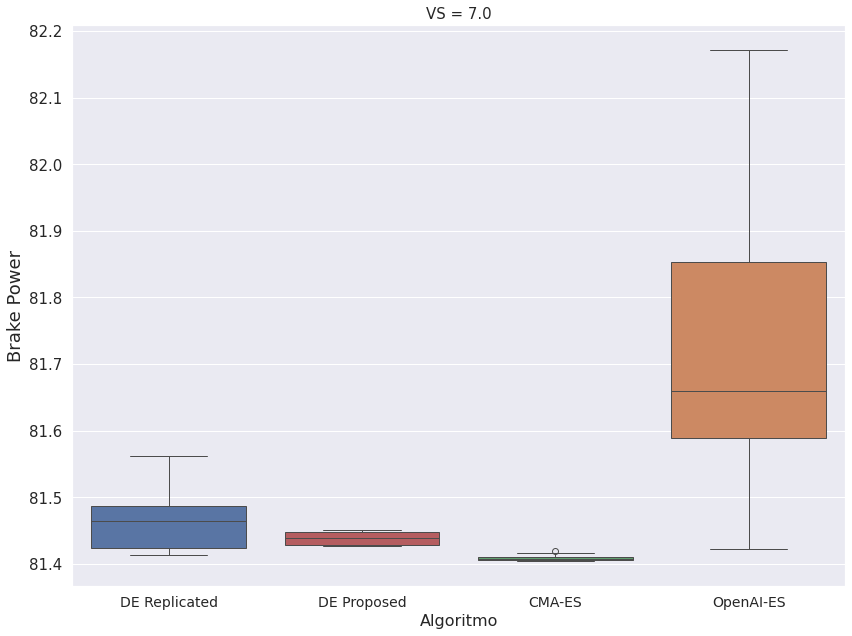

In [36]:
create_img(data = df_vs_7_0,
           order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'OpenAI-ES'],
           name='boxplot_7_0' )

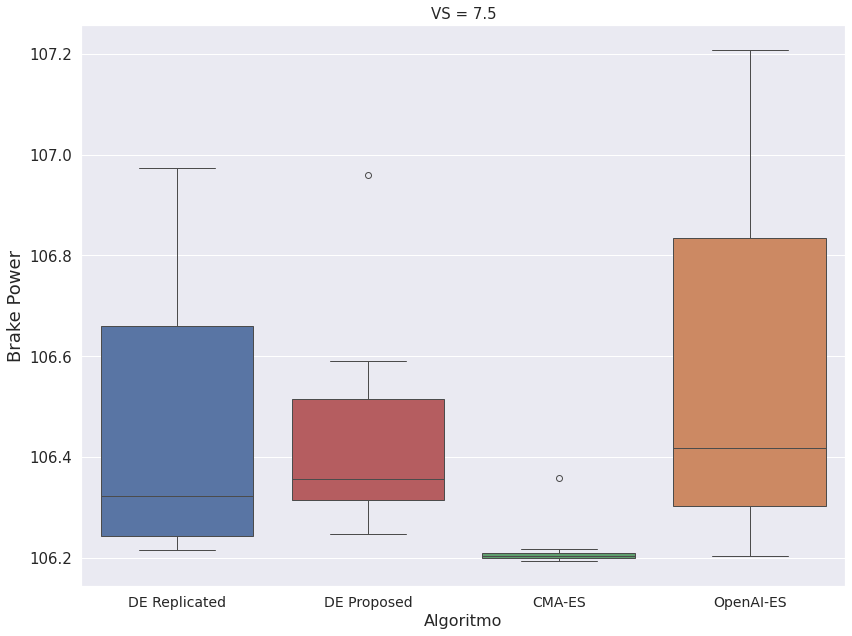

In [29]:
create_img(data = df_vs_7_5,
           order=['DE Replicated', 'DE Proposed', 'CMA-ES', 'OpenAI-ES'],
           name='boxplot_7_5' )

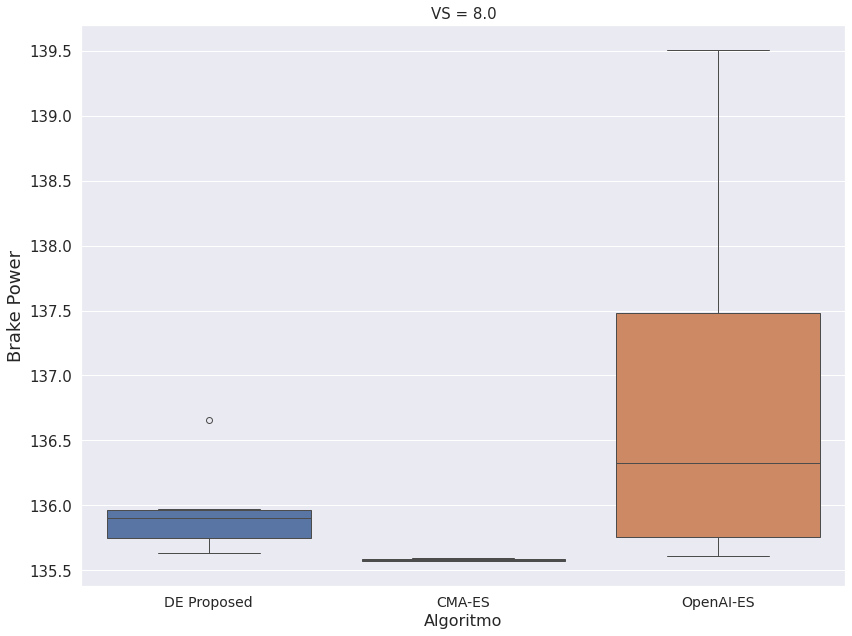

In [30]:
create_img(data = df_vs_8_0,
           order=['DE Proposed', 'CMA-ES', 'OpenAI-ES'],
           name='boxplot_8_0' )

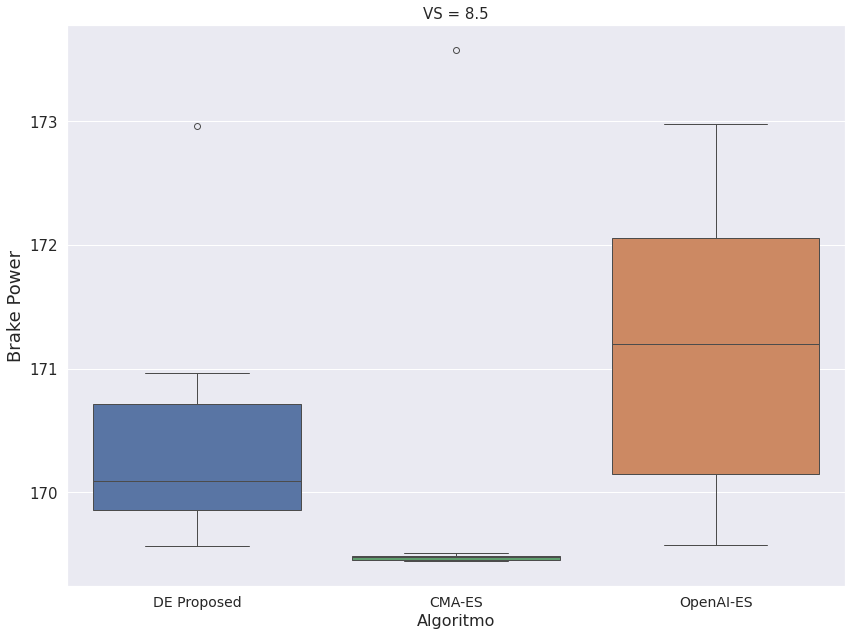

In [31]:
create_img(data = df_vs_8_5,
           order=['DE Proposed', 'CMA-ES', 'OpenAI-ES'],
           name='boxplot_8_5' )

## Double graphs

In [32]:
rename_dict = {'CMA-ES': 'CMA-ES',
               'OpenAI-ES': 'OpenAI-ES',
               'DE Replicated': 'DE\nReplicated',
               'DE Proposed': 'DE\nProposed'
              }

custom_order = {
    'DE\nReplicated': 1,
    'DE\nProposed': 2,
    'CMA-ES': 3,
    'OpenAI-ES': 4
}

In [87]:
font_size = 14

def multiple_boxplot(vs_values, save=True, only_put_1_legend=False):
    # Create subplots with a shared x-axis
    fig, ax = plt.subplots(1, len(vs_values), sharey='col', figsize=(11, 7))

    for i, vs in enumerate(vs_values):
        df_temp = df_results[df_results['VS'] == vs]
        # rename 
        df_temp.loc[:,'Algoritmo'] = df_temp['Algoritmo'].map(rename_dict)
        # Get unique values and sort them based on the custom order
        unique_values = sorted(df_temp['Algoritmo'].unique(), key=lambda x: custom_order[x])

        # create the box plot
        sns.boxplot(y="Brake Power", 
                    x = "Algoritmo",
                    hue = 'Algoritmo',
                    order=unique_values,
#                         palette="hls", # Colors
                    data=df_temp, ax=ax[i])  

        # Set the title for the subplot
        ax[i].set_title(f'VS = {vs}',   fontsize=font_size)
        ax[i].tick_params(axis='both', labelsize=font_size) 
        # Set labels for x and y axes
        ax[i].set_xlabel('Algorithm',   fontsize=font_size)
        ax[i].set_ylabel('Brake Power', fontsize=font_size)

        # ylim
        minmax = df_temp['Brake Power'].agg(['min', 'max']).to_list()
        ax[i].set_ylim(minmax[0]*0.999, minmax[1]*1.001) 
        
        if only_put_1_legend:
            # only put 1 legend
            if i == 1:
        #         ax[i].legend(loc='upper right')
                legend = ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
            else:
                ax[i].legend([],[], frameon=False)

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # save
    if save:
        name_f  = 'boxplot'
        # speed
        name_f += '_' + "and".join([str(v) for v in vs_values])
        name_f  = name_f.replace('.','_')
        # file type
        name_f += '.pdf'
        plt.savefig(name_f, bbox_inches='tight')
        print('saved', name_f)

    # Show the plot
    plt.show()

saved boxplot_7_0and7_5.pdf


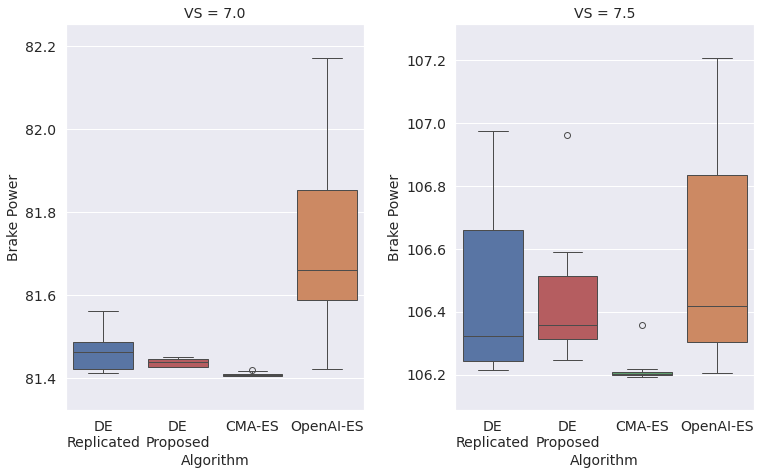

In [88]:
multiple_boxplot([7.0, 7.5])

saved boxplot_8_0and8_5.pdf


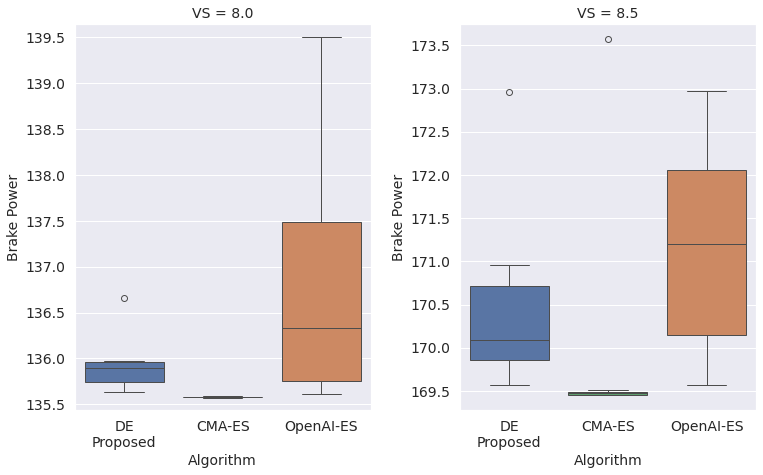

In [89]:
multiple_boxplot([8.0, 8.5])